In [69]:
import pandas as pd
import numpy as np
from pathlib import Path
from definitions import ROOT_DIR
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font',**{'family':'sans-serif',
             'sans-serif':['Arial'],
             'size':16})

- Inputs

In [70]:
p_root_dir = Path(ROOT_DIR).parents[0]
p_data = p_root_dir / "5_data_analysis"
p_out = p_root_dir / "6_plots/q2_plots/dot_plots"

# Metrics and Catboost predictions for all ions in their target wells
p_predictions = p_data / "all_predictions_curated_11-Dec-2021.csv"

# Dataset info (lab, matrix, polarity, m/z range, ids, etc.)
p_datasets = p_data / "datasets.csv"

# Classification
p_chem_class = p_data / "custom_classification_v2.csv"
p_pathways = p_data / "pathways_v2.csv"

- Merge relevant info into one dataframe

In [79]:
def filter_neutral_losses(df, filter_on=True, neutral_losses_to_keep=['']):
    '''
    Filter out entries for ions with neutral losses that are not in the list provided
    '''
    if filter_on==True:
        df = df[df.neutral_loss.isin(neutral_losses_to_keep)]
    elif filter_on == 'only_nl':
        df = df[df.neutral_loss != '']
    return df

def filter_adducts(df, filter_on=True, adducts_to_keep=['']):
    '''
    Filter out entries for ions with adducts that are not in the list provided
    '''
    if filter_on==True:
        df = df[df.adduct.isin(adducts_to_keep)]
    return df


def calculate_detected_intensities(df):
    '''
    Make a column with background corrected intensities for detected compounds, and 0s for not detected compounds
    Change any negative values to zero
    '''
    intensities_for_twostate_spots = (df.pred_twostate == 1) * df.spot_intensity_bgr_corrected
    df['val_twostate'] = np.clip(intensities_for_twostate_spots, 0, None)
    intensities_for_threestate_spots = (df.pred_threestate == 2) * df.spot_intensity_bgr_corrected
    df['val_threestate'] = np.clip(intensities_for_threestate_spots, 0, None)
    return df

def filter_polarity(df, filter_on=True, polarity=None):
    '''
    Filter out entries based on polarity pol ['pos', 'neg']
    '''
    if filter_on==True:
        df = df[df['Polarity'] == polarity]
    return df

def group_by_molecule(df, intensity_col_name, prediction_col_name):
    '''
    Aggregate intensity and detection values per class
    '''
    
    if intensity_col_name == 'val_threestate':
        intensity_aggregation_func = lambda x: (x==2).any()
    else: intensity_aggregation_func = lambda x: (x==1).any()
            
    
    data = df.pivot_table(index=['name_short'],
                          columns=['sample_name'],
                          values=[intensity_col_name, prediction_col_name],
                          aggfunc = {
                                intensity_col_name : lambda x: np.log10(sum(x)+1),
                                prediction_col_name : intensity_aggregation_func
                          },
                          fill_value=0,
                          sort=False)
    data = data.stack(level=1, dropna=False).reset_index()
    # If no ions on a molecule were detected by matrix, prediction column contains fill value 0 instead of False, correct for that:
    data.at[data[prediction_col_name] == 0, prediction_col_name] = False
    return data

def prep_molecule_data(data, polarity_filter_on, intensity_col_name, prediction_col_name, polarity=None, adduct_filter_on=False, adducts_to_keep=None, nl_filter_on=False, neutral_losses_to_keep=None):
    '''
    '''
    
    data = filter_adducts(data, adduct_filter_on, adducts_to_keep)
    data = filter_neutral_losses(data, nl_filter_on, neutral_losses_to_keep)
    data = calculate_detected_intensities(data)
    data = filter_polarity(data, polarity_filter_on, polarity)
    data = group_by_molecule(data, intensity_col_name, prediction_col_name)
    
    return data

In [75]:
# Load predictions, format neutral loss column
predictions = pd.read_csv(p_predictions, index_col=0)
predictions.neutral_loss.fillna('', inplace=True)

# TODO: remove thermometer ions

chem_class = pd.read_csv(p_chem_class, index_col='internal_id')
main_chem_class = chem_class[['name_short', 'main_coarse_class']].drop_duplicates()
pathways = pd.read_csv(p_pathways, index_col='internal_id')
main_pathways = pathways[['name_short', 'main_coarse_path']].drop_duplicates()

# Get a subset of most relevant information from Datasets file
datasets = pd.read_csv(p_datasets)
datasets_info = datasets.groupby('Clone ID').first()[['Polarity', 'Matrix short', 'Matrix long', 'Slide code']] # 'Participant lab', 'Technology'
datasets_info['sample_name'] = datasets_info['Matrix short']
# datasets_info['sample_name'] = datasets_info['Matrix short'] + '_' + datasets_info['Slide code']

# Merge with predictions and classification
df = pd.merge(predictions, datasets_info, left_on='dataset_id', right_on='Clone ID', how='left')

### Part 1: Dot plot with main chemical classes or pathways

In [5]:
# Choose colourmap
cmap = sns.choose_colorbrewer_palette('s', as_cmap=True)

interactive(children=(Dropdown(description='name', options=('Greys', 'Reds', 'Greens', 'Blues', 'Oranges', 'Pu…

In [73]:
def summarise_per_coarse_class(df, class_col_name, intensity_col_name, prediction_col_name):
    
    df['class_size'] = 1
    data = df.pivot_table(index=['sample_name'],
                                   columns=class_col_name,
                                   values=[intensity_col_name, prediction_col_name, 'class_size'],
                                   aggfunc = {
                                        'class_size':sum,
                                        prediction_col_name : sum,
                                        intensity_col_name : np.mean
                                   },
                                   fill_value=0,
                                   sort=False)
    
    data = data.stack(level=1, dropna=False).reset_index()
    data['fraction_detected'] = data[prediction_col_name] / data['class_size']
    
    
    # sort columns alphabetically
    data = data.sort_values(by='sample_name')    
    return data

def plot_coarse_dot_plot(plot_data, cmap, class_col_name, intensity_col_name, title="", figsize=(12,4.5)):
    
    plt.figure(figsize=figsize)
    g = sns.scatterplot(data=plot_data, 
                        x='sample_name', 
                        y=class_col_name, 
                        size="fraction_detected", 
                        sizes=(0, 400), #smallest and largest bubble size to use
                        size_norm=(0, 1), #fraction range
                        hue=intensity_col_name, 
                        hue_norm=(0, 5), #intensity range
                        palette=cmap,
#                         linewidth = 1,
                        edgecolor='k',
                        legend='brief'
            )

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, frameon=False)
    plt.title(title)
    plt.xlabel("")
    plt.ylabel("")
    plt.xticks(rotation=90)
    plt.tight_layout()

    return g

#### size_norm and hue_norm make sure the same dot size and colour limits apply to all plots, but it is not evident from the way legend is shown. If you want to double check, set legend='full' in plot function call

<ipython-input-37-f7de0d061d6a>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['val_twostate'] = np.clip(intensities_for_twostate_spots, 0, None)
<ipython-input-37-f7de0d061d6a>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['val_threestate'] = np.clip(intensities_for_threestate_spots, 0, None)


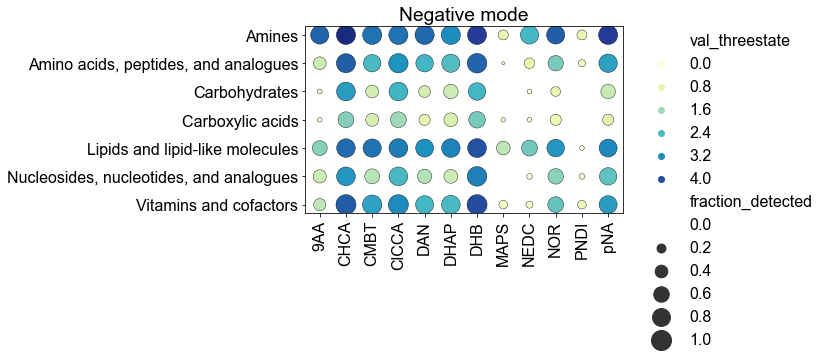

In [40]:
# Summarise data per molecule (intensities of its detected ions are summed)
molecule_data = prep_molecule_data(df,
                                   polarity='pos', 
                                   adduct_filter_on=False,
                                   adducts_to_keep=None,
                                   nl_filter_on=True, 
                                   neutral_losses_to_keep=[''], 
                                   intensity_col_name='val_threestate',
                                   prediction_col_name = 'pred_threestate')

# Map chemical classes
mapped_data = molecule_data.merge(main_chem_class, on='name_short', how='left') #chem_class of pathways

# Summarise data per class
class_data = summarise_per_coarse_class(mapped_data,
                                        class_col_name='main_coarse_class',
                                        intensity_col_name ='val_threestate',
                                        prediction_col_name = 'pred_threestate')

plot = plot_coarse_dot_plot(class_data, cmap, 
              class_col_name='main_coarse_class', 
              intensity_col_name = 'val_threestate',
              title = 'Negative mode',
              figsize=(12,4.5))

# plot.figure.savefig(p_out / f"Dotplot_coarse_class_neg_3_noNL.pdf")

- Batch-save many plots with changing filters:

1. With and without neutral losses
2. In both ionisation modes
3. With 50% (val_twostate) or 80% (val_threestate) ion detection confidence

In [67]:
for nl_filter_on in [True, False, 'only_nl']:
    
    nl_label = 'with n.l.'
    if nl_filter_on==True: 
        nl_label = 'no n.l.'  
    elif nl_filter_on == 'only_nl':
        nl_label = 'only n.l.'    
    
    for polarity in ['pos', 'neg']:
        
        for catboost in ['threestate']: #'twostate'

            # Summarise data per molecule (intensities of its detected ions are summed)
            molecule_data = prep_molecule_data(df,
                                               polarity=polarity, 
                                               nl_filter_on=nl_filter_on, 
                                               neutral_losses_to_keep=[''], 
                                               intensity_col_name=f'val_{catboost}',
                                               prediction_col_name = f'pred_{catboost}')

            # Map chemical classes
            for class_col_name in ['main_coarse_class', 'main_coarse_path']:
                
                if class_col_name == 'main_coarse_class':
                    mapped_data = molecule_data.merge(main_chem_class, on='name_short', how='left')
                elif class_col_name == 'main_coarse_path':
                    mapped_data = molecule_data.merge(main_pathways, on='name_short', how='left')                   

                    
            # Summarise data per class
                class_data = summarise_per_coarse_class(mapped_data,
                                                        class_col_name=class_col_name,
                                                        intensity_col_name =f'val_{catboost}',
                                                        prediction_col_name = f'pred_{catboost}')
            #Make the plot
                title = f"Fraction and avg.intensity {polarity} {catboost} {nl_label} {class_col_name}"
                g = plot_coarse_dot_plot(class_data, cmap, 
                                         class_col_name=class_col_name, 
                                         intensity_col_name = f'val_{catboost}',
                                         title=title)
            # Save the plot
                g.figure.savefig(p_out / f"{title}.png")
                plt.close()  

<ipython-input-63-65971929296a>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['val_twostate'] = np.clip(intensities_for_twostate_spots, 0, None)
<ipython-input-63-65971929296a>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['val_threestate'] = np.clip(intensities_for_threestate_spots, 0, None)
<ipython-input-63-65971929296a>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

# Part 2: Dot plot with fine chemical classes or pathways

In [33]:
def summarise_per_fine_class(df, fine_class_col_name, coarse_class_col_name, intensity_col_name, prediction_col_name):
    
    df['class_size'] =1
    data = df.pivot_table(index=['sample_name'],
                                   columns=[fine_class_col_name, coarse_class_col_name],
                                   values=[intensity_col_name, prediction_col_name, 'class_size'],
                                   aggfunc = {
                                        'class_size':sum,
                                        prediction_col_name : sum,
                                        intensity_col_name : np.mean
                                   },
                                   fill_value=0,
                                   sort=False)
    
    data = data.stack(level=[1,2], dropna=True).reset_index()
    data['fraction_detected'] = data[prediction_col_name] / data['class_size']    
    
    # sort columns alphabetically
    data = data.sort_values(by='sample_name')
    # sort rows first by coarse class, then by fine class
    data = data.sort_values(by=[coarse_class_col_name, fine_class_col_name])
    return data

def plot_fine_dot_plot(plot_data, cmap, class_col_name, intensity_col_name, title=""):
    
    plt.figure(figsize=(12,12))
    g = sns.scatterplot(data=plot_data, 
                        x='sample_name', 
                        y=class_col_name, 
                        size="fraction_detected", 
                        sizes=(0, 300), #smallest and largest bubble size to use
                        size_norm=(0, 1), #fraction range
                        hue=intensity_col_name, 
                        hue_norm=(0, 5), #intensity range
                        palette=cmap,
                        linewidth = 0.5,
                        edgecolor='k',
                        legend='brief'
            )
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.title(title)
    plt.xlabel("")
    plt.ylabel("")
    plt.xticks(rotation=90)
    plt.tight_layout()

    return g

In [26]:
# Choose colourmap
cmap = sns.choose_colorbrewer_palette('s', as_cmap=True)

interactive(children=(Dropdown(description='name', options=('Greys', 'Reds', 'Greens', 'Blues', 'Oranges', 'Pu…

<ipython-input-3-f7de0d061d6a>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['val_twostate'] = np.clip(intensities_for_twostate_spots, 0, None)
<ipython-input-3-f7de0d061d6a>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['val_threestate'] = np.clip(intensities_for_threestate_spots, 0, None)


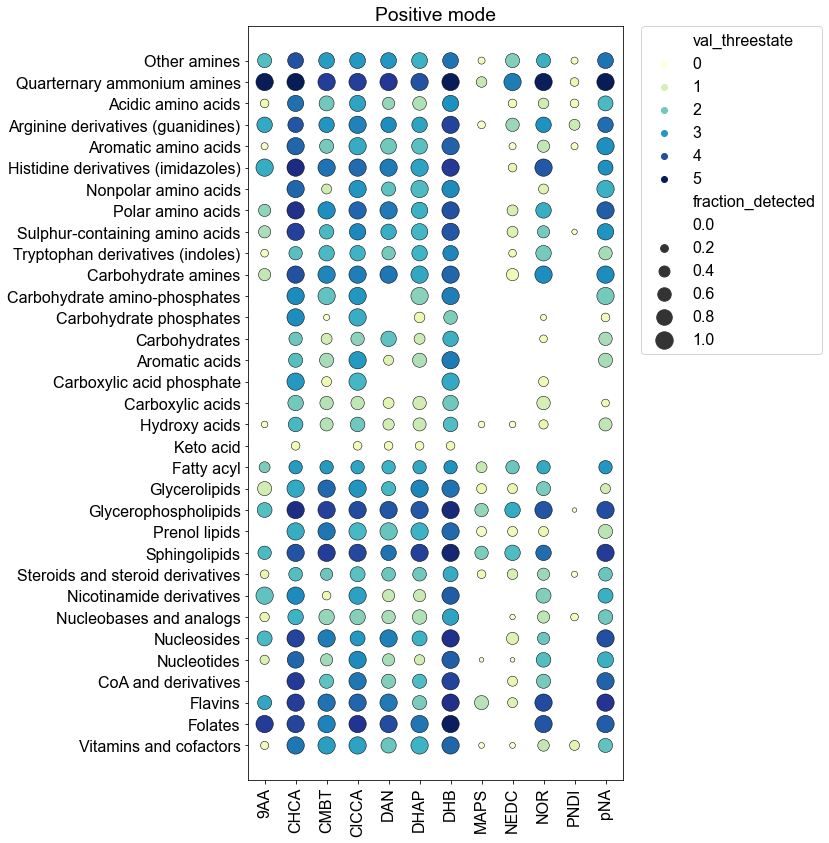

In [34]:
# Summarise data per molecule (intensities of its detected ions are summed)
molecule_data = prep_molecule_data(df,
                                   polarity='pos',
                                   adduct_filter_on=False,
                                   adducts_to_keep=None,
                                   nl_filter_on=True, 
                                   neutral_losses_to_keep=[''], 
                                   intensity_col_name='val_threestate',
                                   prediction_col_name = 'pred_threestate')

# Map chemical classes
mapped_data = molecule_data.merge(chem_class, on='name_short', how='left') #pathways or chem_class

# Summarise data per class
class_data = summarise_per_fine_class(mapped_data,
                                      fine_class_col_name='fine_class',
                                      coarse_class_col_name='coarse_class',
                                      intensity_col_name ='val_threestate',
                                      prediction_col_name = 'pred_threestate')

plot = plot_fine_dot_plot(class_data, cmap, 
                   class_col_name='fine_class', 
                   intensity_col_name = 'val_threestate',
                   title="Positive mode")

# plot.figure.savefig(p_out / f"Dotplot_fine_path_pos_3_noNL.pdf")

- Batch-save many plots with changing filters:

1. With and without neutral losses
2. In both ionisation modes
3. With 50% (val_twostate) or 80% (val_threestate) ion detection confidence

In [70]:
for nl_filter_on in [True, False, 'only_nl']:
    
    nl_label = 'with n.l.'
    if nl_filter_on==True: 
        nl_label = 'no n.l.'  
    elif nl_filter_on == 'only_nl':
        nl_label = 'only n.l.'
    
    for polarity in ['pos', 'neg']:
        
        for catboost in ['threestate']: #'twostate'

            # Summarise data per molecule (intensities of its detected ions are summed)
            molecule_data = prep_molecule_data(df,
                                               polarity=polarity, 
                                               nl_filter_on=nl_filter_on, 
                                               neutral_losses_to_keep=[''], 
                                               intensity_col_name=f'val_{catboost}',
                                               prediction_col_name = f'pred_{catboost}')

            # Map chemical classes
            for fine_class_col_name, coarse_class_col_name in [('fine_class', 'coarse_class'), ('fine_path', 'coarse_path')]:
                
                if fine_class_col_name == 'fine_class':
                    mapped_data = molecule_data.merge(chem_class, on='name_short', how='left')
                elif fine_class_col_name == 'fine_path':
                    mapped_data = molecule_data.merge(pathways, on='name_short', how='left')                   

                    
            # Summarise data per class
                class_data = summarise_per_fine_class(mapped_data,
                                                      fine_class_col_name=fine_class_col_name,
                                                      coarse_class_col_name=coarse_class_col_name,
                                                      intensity_col_name =f'val_{catboost}',
                                                      prediction_col_name = f'pred_{catboost}')
           
            # Make the plot     
                title = f"Fraction and mean log10 intensity {nl_label} {polarity} {catboost} {fine_class_col_name}"
                g = plot_fine_dot_plot(class_data, cmap, 
                                  class_col_name=fine_class_col_name, 
                                  intensity_col_name = f'val_{catboost}',
                                  title=title)
            # Save the plot
                g.figure.savefig(p_out / f"{title}.png")
                plt.close()  

<ipython-input-63-65971929296a>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['val_twostate'] = np.clip(intensities_for_twostate_spots, 0, None)
<ipython-input-63-65971929296a>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['val_threestate'] = np.clip(intensities_for_threestate_spots, 0, None)
<ipython-input-63-65971929296a>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 